# Image Cross-Correlation of Ball Viscometer

This program tracks a ball bearing moving in a sequence of high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 07/06/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
#from scipy.interpolate import interp2d
#import scipy.integrate, scipy.signal
#from joblib import Parallel, delayed
%matplotlib notebook

In [61]:
# Read images.
srcdir = "/Users/dduke/Desktop/Viscosity_mp4/vis_Inclination_50/"
SPATIAL_RES = None # pixel per micron
FRAME_RATE = 500. # frames/s
THETA = 50 * np.pi/180. # angle

I=ImageSequence(srcdir, IO_threads=4)

Reading /Users/dduke/Desktop/Viscosity_mp4/vis_Inclination_50/
	Found 930 images with extension .tiff
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    4.9s finished


Read 499.5 MiB in 5.6 sec
	Data in memory:	 (930, 220, 1280)
	Intensity range:	 0 to 38920 	 uint32
	Array size:	999.0 MB


In [62]:
I.crop(0,220,175,718)

## Remove image background
Division method

In [63]:
# No background removal?
#Ib=I.arr/np.nanmax(I.arr)

# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(I.arr[:5,...].astype(np.float32),axis=0) # First 5 images are reference background
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd  # Division

# Convert to extinction
Ib = 1.0 - Ib

<IPython.core.display.Javascript object>


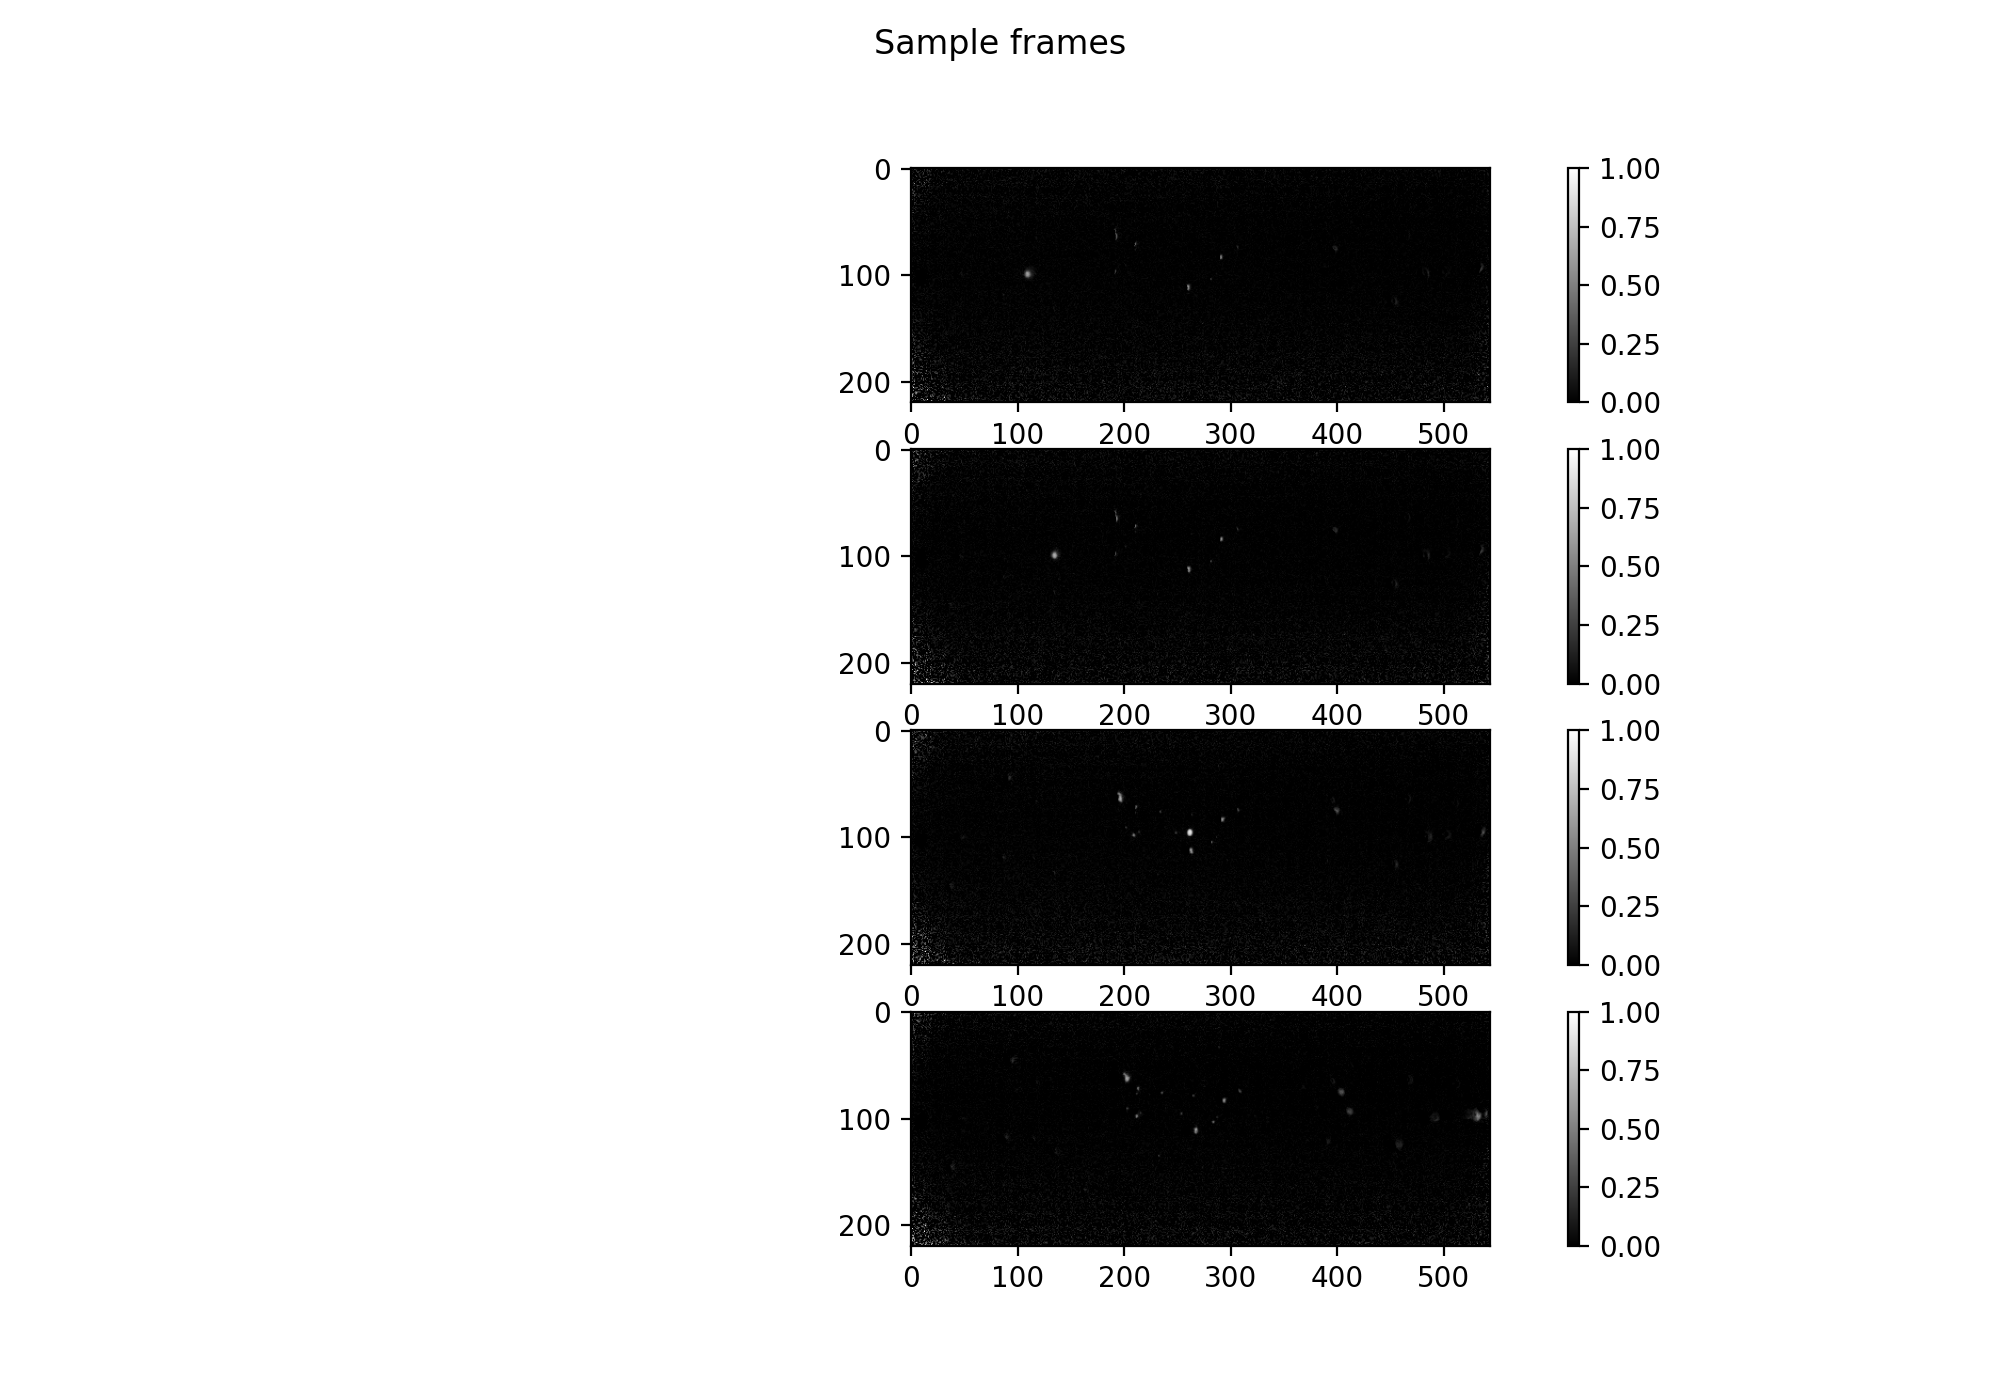

In [64]:
# Show some samples
fig=plt.figure(figsize=(10,7))
plt.suptitle("Sample frames\n"+os.path.basename(srcdir))
ax=fig.add_subplot(411)
h=ax.imshow(Ib[int(I.N/5),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h)
ax=fig.add_subplot(412)
h=ax.imshow(Ib[int(I.N/4),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(413)
h=ax.imshow(Ib[int(I.N/2),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(414)
h=ax.imshow(Ib[I.N-1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);

## Find the approximate position of the ball in each image
Look for local maximum in the extinction signal.

In [213]:
INTENSITY_THRESHOLD=0.67
Y_MARGIN_PX = 25
X_MIN_PX = 190
X_MAX_PX = -20

# Get location of the peak if it is above a threshold and not too close to the edge of the image.
xy_peak = []; maxvals=[]
for i in range(I.N):
    maxval=np.nanmax(Ib[i,Y_MARGIN_PX:-Y_MARGIN_PX,X_MIN_PX:X_MAX_PX])
    if maxval<INTENSITY_THRESHOLD: 
        xy_peak.append((np.nan,np.nan))
    else:
        xy=np.where(Ib[i,Y_MARGIN_PX:-Y_MARGIN_PX,X_MIN_PX:X_MAX_PX]==maxval)
        xy_peak.append((xy[1][0]+X_MIN_PX,xy[0][0]+Y_MARGIN_PX))
    maxvals.append(maxval)
xy_peak = np.array(xy_peak).astype(float)

<IPython.core.display.Javascript object>


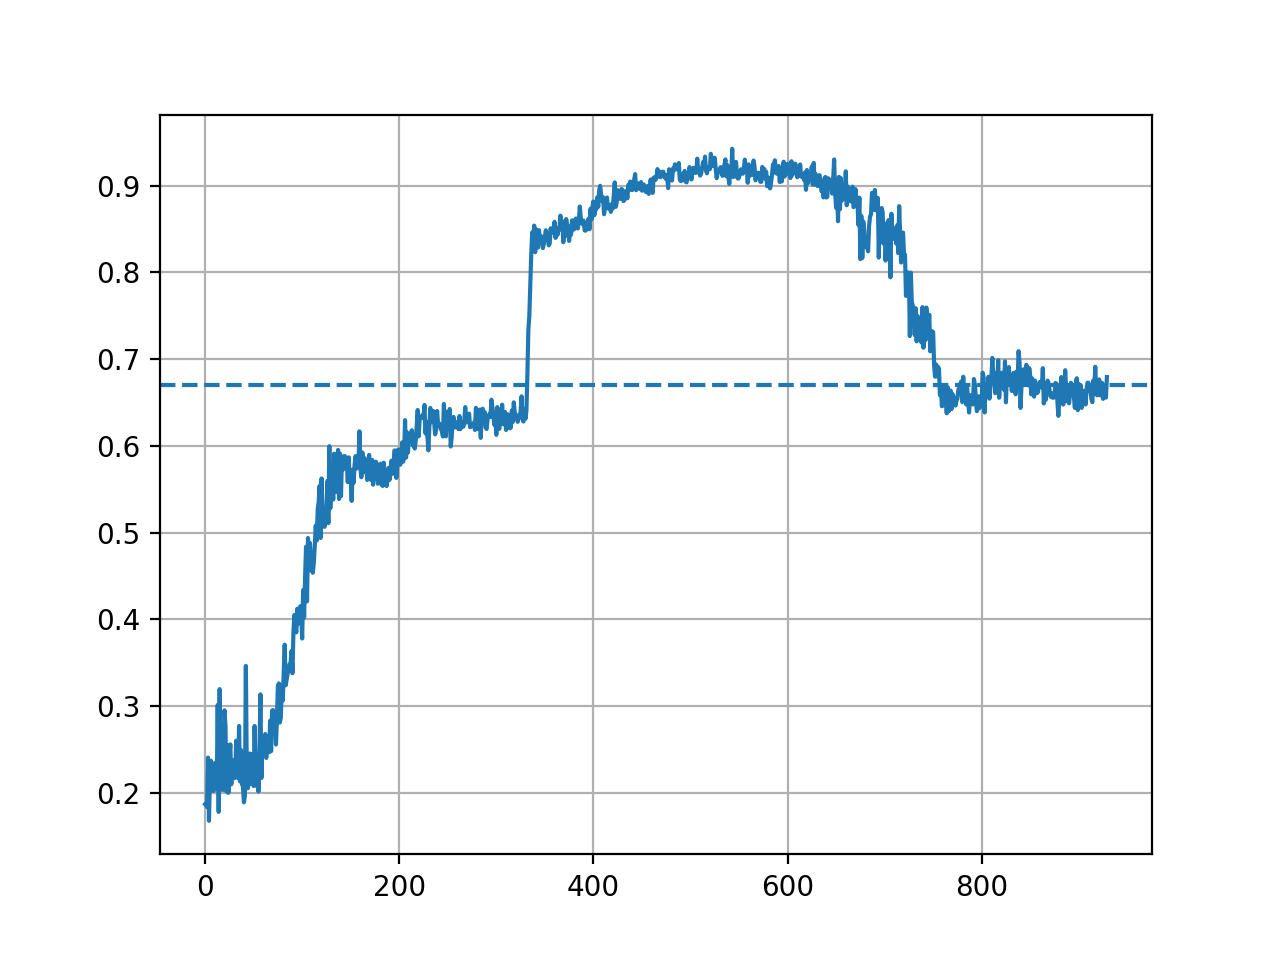

In [214]:
# Check the threshold for detecting the ball
fig=plt.figure()
plt.grid()
plt.plot(maxvals)
plt.axhline(INTENSITY_THRESHOLD,ls='--')
plt.show()

In [215]:
# Remove any outliers based on a maximum displacement.
MAX_DS_PX=5.0

dx = np.hstack((0,np.diff(xy_peak[:,0]) ))
dy = np.hstack((0,np.diff(xy_peak[:,1]) ))
ds = np.nan_to_num(np.sqrt(dx**2 + dy**2))
xy_peak[ds>MAX_DS_PX,:] = np.nan
ds[ds>MAX_DS_PX]=np.nan

<IPython.core.display.Javascript object>


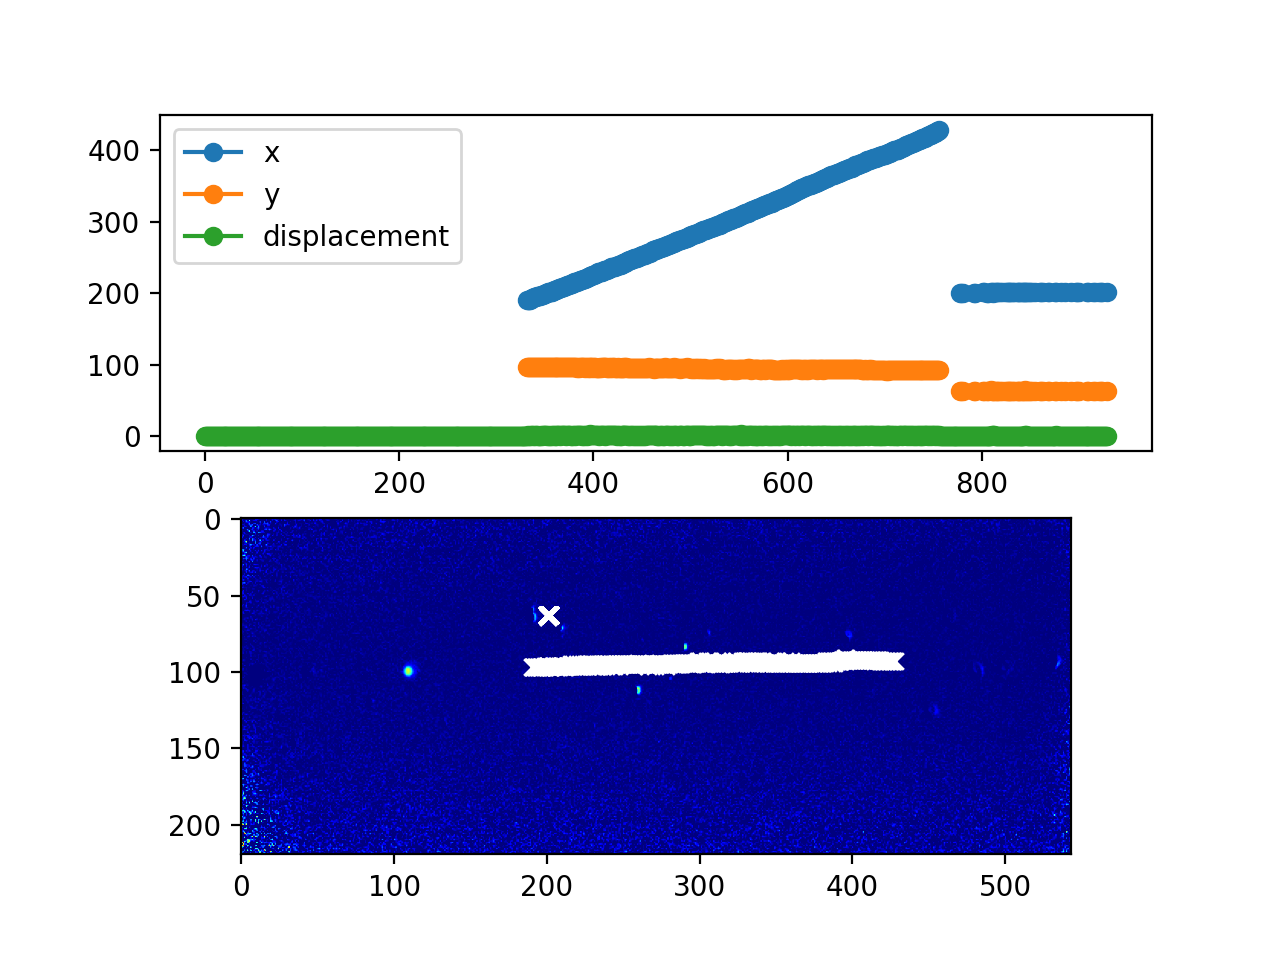

In [216]:
n=int(I.N/5)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xy_peak,marker='o')
ax.plot(ds,marker='o')
plt.legend(['x','y','displacement'])
ax=fig.add_subplot(212)
h=ax.imshow(Ib[n,...],cmap=plt.cm.jet,vmin=0,vmax=1)
ax.scatter(xy_peak[:,0],xy_peak[:,1],marker='x',lw=1,c='w',zorder=2)
#plt.colorbar(h)
plt.show()

# Plot displacement etc. vs time

<IPython.core.display.Javascript object>


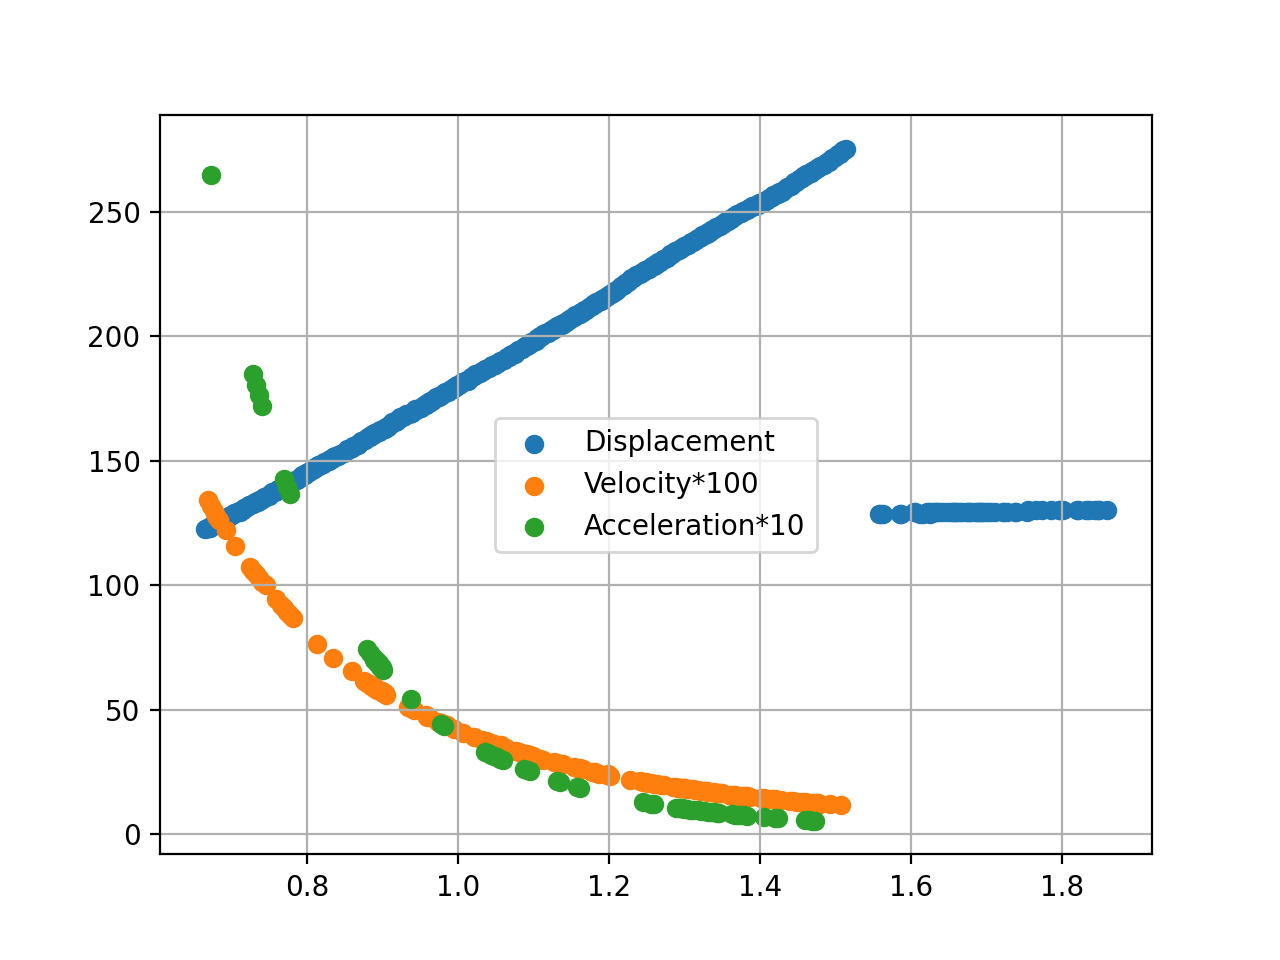

In [220]:
# Correcting for out of plane angle to convert to displacement parallel to surface.
s = np.sqrt( (xy_peak[:,0]*np.cos(THETA))**2 + xy_peak[:,1] )
t = np.linspace( 0, I.N/float(FRAME_RATE), I.N )

# 2nd order central difference using every 2nd point
m=2
v=np.array([ (s[i+m] - 2*s[i] + s[i-m])*(FRAME_RATE/m)**2 for i in range(m,len(s)-m) ])
v[np.abs(v)>100]=0
v[v==0]=np.nan

m2=2
a=np.array([ (v[i+m2] - 2*v[i] + v[i-m2])*(FRAME_RATE/m2)**2 for i in range(m2,len(v)-m2) ])
a[np.abs(a)>5000]=np.nan


fig=plt.figure()
ax=fig.add_subplot(111)
ax.grid()
ax.scatter(t,s)
ax.scatter(t[m:-m],v*100)
ax.scatter(t[m+m2:-m-m2],a*10)
plt.legend(['Displacement','Velocity*100','Acceleration*10'])
plt.show()